In [1]:
# !pip install d2l
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [2]:
# define model
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

train_imgs = torchvision.datasets.DTD(root='', download=True, split='train', transform=train_augs)
test_imgs = torchvision.datasets.DTD(root='', download=True, split='test', transform=test_augs)

train_loader = DataLoader(train_imgs, batch_size=64, shuffle=True)
test_loader = DataLoader(test_imgs, batch_size=64, shuffle=False)

NUM_CLASSES = len(train_imgs.classes)

In [ ]:
import torchvision.models as models

def train_fine_tuning(net, learning_rate, num_epochs=5,
                      fine_tuning_type=None, train_iter=None, test_iter=None):
    devices = [torch.device('cpu')]
    print(devices)
    loss = nn.CrossEntropyLoss(reduction="none")
    if fine_tuning_type == "full_ft":
        backbone_params = [p for name, p in net.named_parameters() if 'classifier' not in name]
        trainer = torch.optim.SGD([
            {'params': backbone_params},
            {'params': net.classifier[-1].parameters(), 'lr': learning_rate * 10}
        ], lr=learning_rate, weight_decay=0.0001)
    elif fine_tuning_type == "lora":
        paras = []
        for name, param in net.named_parameters():
            if "classifier" in name:  # Example: Update classifier only
                paras.append({"params": param, "lr": learning_rate * 10})
            else:
                param.requires_grad = False
        trainer = torch.optim.SGD(paras, lr=learning_rate,
                                  weight_decay=0.0001)
    elif fine_tuning_type == "lp":
        paras = []
        for name, param in net.named_parameters():
            if "classifier.6" in name:  # Only update last FC layer
                paras.append({"params": param, "lr": learning_rate * 10})
            else:
                param.requires_grad = False
        trainer = torch.optim.SGD(paras, lr=learning_rate,
                                  weight_decay=0.0001)
    else:
        raise ValueError("Unknown fine tuning type")
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

KeyboardInterrupt: 

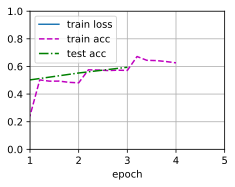

In [12]:
net = torchvision.models.vgg11(pretrained=True)
net.classifier[-1] = nn.Linear(net.classifier[-1].in_features, NUM_CLASSES)
nn.init.xavier_uniform_(net.classifier[-1].weight);
train_fine_tuning(net, 1e-4, fine_tuning_type='full_ft', train_iter=train_loader, test_iter=test_loader)

In [ ]:
net = torchvision.models.vgg11(pretrained=True)
net.classifier[-1] = nn.Linear(net.classifier[-1].in_features, NUM_CLASSES)
nn.init.xavier_uniform_(net.classifier[-1].weight);
train_fine_tuning(net, 1e-3, fine_tuning_type='lp', train_iter=train_loader, test_iter=test_loader)

In [21]:
import torch
import torch.nn as nn
import math

class LoRALayer(nn.Module):
    def __init__(self, original_layer, r=8):
        super(LoRALayer, self).__init__()
        self.original_layer = original_layer
        self.r = r
        in_features, out_features = original_layer.weight.shape
        self.lora_A = nn.Linear(in_features, r, bias=False) # TODO: complete it init with a normal distribution with standard deviation σ = 0.01
        nn.init.normal_(self.lora_A.weight, mean=0.0, std=0.01)
        # LoRA B: Projects from r -> output_dim, initialized to zero
        self.lora_B = nn.Linear(r, out_features, bias=False)
        nn.init.zeros_(self.lora_B.weight)

    def forward(self, x):
        # TODO: complete it
        return self.original_layer(x) + (x @ self.lora_B.T @ self.lora_A.T)

[device(type='cpu')]


AttributeError: 'Linear' object has no attribute 'T'

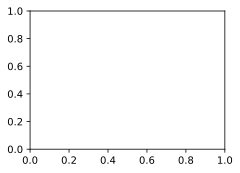

In [22]:
net = torchvision.models.vgg11(pretrained=True)
net.classifier[-1] = nn.Linear(net.classifier[-1].in_features, NUM_CLASSES)
nn.init.xavier_uniform_(net.classifier[-1].weight);

for name, module in net.named_modules():
    if name in ['classifier.0', 'classifier.3']:
        parent = net
        *parent_names, target_name = name.split('.')
        for pname in parent_names:
            parent = getattr(parent, pname)
        original_layer = getattr(parent, target_name)
        lora_layer = LoRALayer(original_layer, r=4)
        setattr(parent, target_name, lora_layer)
train_fine_tuning(net, 1e-3, fine_tuning_type='lora', train_iter=train_loader, test_iter=test_loader)